<a href="https://colab.research.google.com/github/MMathisLab/CEBRA-demos/blob/main/CEBRA_best_practices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Best Practices for training CEBRA models

In this notebook, we show how to

- Use CEBRA-Time and CEBRA-Behavior.
- Perform a grid search.
- Perform train/validation splits.
- Run controls with shuffled data.
- Compute and display the consistency between runs.
- Check the loss functions.


In [ ]:
!pip install --pre 'cebra[datasets,integrations]'

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

#for model saving:
import os
import tempfile
from pathlib import Path

# 1. Set up a CEBRA model

## Items to consider

- We recommend starting with an unsupervised approach (CEBRA-Time).
- We recommend starting with defaults, then performing a grid search.
- We are going to largely follow the recommendations from our [Quick Start scikit-learn API](https://cebra.ai/docs/usage.html#quick-start-scikit-learn-api-example)

In [3]:
# 1. Define a CEBRA model
cebra_model = CEBRA(
    model_architecture="offset10-model", #consider: "offset10-model-mse" if Euclidean
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.12,
    max_iterations=5000, #we will sweep later; start with default
    conditional='time', #for supervised, put 'time_delta', or 'delta'
    output_dimension=3,
    distance='cosine', #consider 'euclidean'; if you set this, output_dimension min=2
    device="cuda_if_available",
    verbose=True,
    time_offsets=10
)

# 2. Load the data

- (or adapt and use your data)
- We are going to use demo data. The data will be automatically downloaded into a `/data` folder.

In [4]:
#2. example data
%mkdir data
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

100%|██████████| 10.0M/10.0M [00:02<00:00, 4.64MB/s]

Download complete. Dataset saved in 'data/rat_hippocampus/achilles.jl'


### Visualize the data

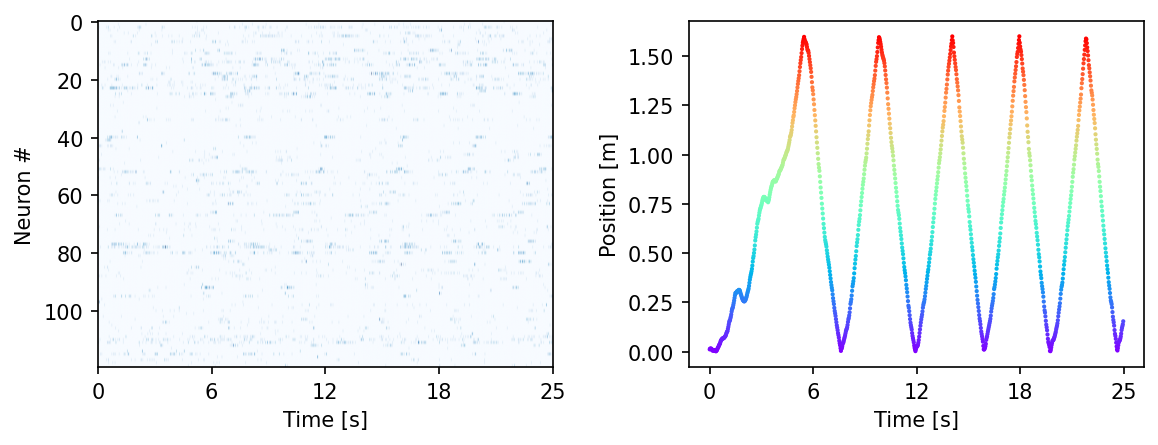

In [5]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'Blues')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos.continuous_index[:1000, 0],
            c=hippocampus_pos.continuous_index[:1000, 0], cmap='rainbow', s=1)

plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

# Quick test: Train CEBRA-Time on the full data (not train/validation yet)...

- This is a rapid quick start, just training without labels on the full dataset on the model we set up above! Here, we should already see a nice structured embedding.
- Note, the colors here are post-hoc applied; positional information was not used to train the model.

pos: -0.8530 neg:  6.3682 total:  5.5152 temperature:  1.1200: 100%|██████████| 5000/5000 [00:46<00:00, 106.72it/s]
100%|██████████| 500/500 [00:01<00:00, 279.88it/s]


 GoF in bits - full: 1.0418257886004874


<Figure size 500x500 with 0 Axes>

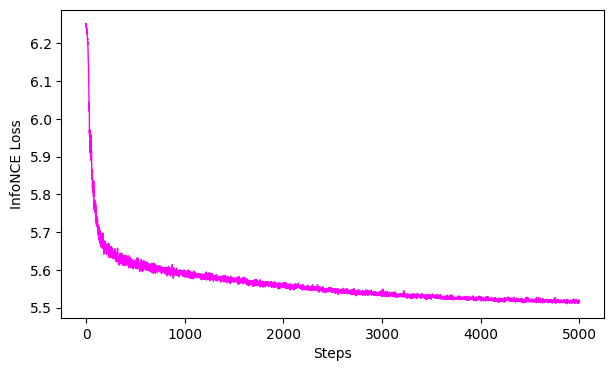

In [6]:
# fit
cebra_time_full_model = cebra_model.fit(hippocampus_pos.neural)
# transform
cebra_time_full = cebra_model.transform(hippocampus_pos.neural)
# GoF
gof_full = cebra.sklearn.metrics.goodness_of_fit_score(cebra_time_full_model, hippocampus_pos.neural)
print(" GoF in bits - full:", gof_full)
# plot embedding
fig = cebra.integrations.plotly.plot_embedding_interactive(cebra_time_full, embedding_labels=hippocampus_pos.continuous_index[:,0], title = "CEBRA-Time (full)", markersize=3, cmap = "rainbow")
fig.show()
# plot the loss curve
ax = cebra.plot_loss(cebra_time_full_model)

# 3. Create a Train/Validation Split

- now that we know we get something decent (see structure, proper loss curve), we can properly test parameters.

In [7]:
# 3. Split data and labels
from sklearn.model_selection import train_test_split

(
    train_data,
    valid_data,
    train_continuous_label,
    valid_continuous_label,
) = train_test_split(hippocampus_pos.neural,
                    hippocampus_pos.continuous_index.numpy(),
                    test_size=0.2) #suggest: 5%-20% depending on your dataset size

# 4. Fit the train split model

In [8]:
cebra_train_model = cebra_model.fit(train_data)#, train_continuous_label)

pos: -0.7801 neg:  6.3733 total:  5.5932 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.10it/s]


# 5. Save the model [optional]

In [9]:
tmp_file = Path(tempfile.gettempdir(), 'cebra.pt')
cebra_train_model.save(tmp_file)
#reload
cebra_train_model = cebra.CEBRA.load(tmp_file)

# 6. Compute (tranform) the embedding

In [10]:
train_embedding = cebra_train_model.transform(train_data)
valid_embedding = cebra_train_model.transform(valid_data)

# 7. Evaluate the Model
- Plot the loss curve
- We can also look at the Goodness of Fit this in bits vs. the infoNCE loss. [See more info here](https://cebra.ai/docs/api/sklearn/metrics.html#cebra.integrations.sklearn.metrics.goodness_of_fit_score)
 - ProTip: 0 bits would be a perfectly collapsed embedding.

100%|██████████| 500/500 [00:01<00:00, 283.05it/s]


 bits - train: 0.9246829291702255


100%|██████████| 500/500 [00:01<00:00, 282.90it/s]


 bits - valid: -0.165028320457561


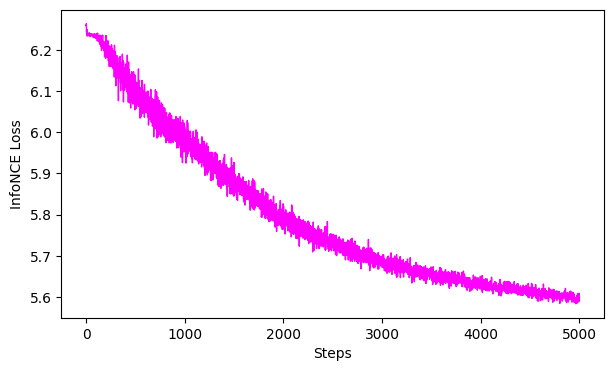

In [11]:
gof_train = cebra.sklearn.metrics.goodness_of_fit_score(cebra_train_model, train_data)
print(" bits - train:", gof_train)

gof_valid = cebra.sklearn.metrics.goodness_of_fit_score(cebra_train_model, valid_data)
gof_valid
print(" bits - valid:", gof_valid)

# plot the loss curve
ax = cebra.plot_loss(cebra_train_model)

## Visualize the embeddings

- train, then validation

In [12]:
import cebra.integrations.plotly
#train
fig = cebra.integrations.plotly.plot_embedding_interactive(train_embedding,
                                                           embedding_labels=train_continuous_label[:,0],
                                                           title = "CEBRA-Time Train",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()

#validation
fig = cebra.integrations.plotly.plot_embedding_interactive(valid_embedding,
                                                           embedding_labels=valid_continuous_label[:,0],
                                                           title = "CEBRA-Time-validation",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

# Next sanity/validation steps:

What did we check above?
 - (1) do we see structure in our embedding? (if not, something is off!)
 - (2) is the GoF reasonable? (infoNCE low, bits high)
 - (3) Is the loss converging without overfitting (no sudden drop after many interations?)

IF 1-3 are not satisfactory, skip to the **Grid Search Below!**

Beyond these being met, we need to check the consistency across runs! In addition to the above checks, once we have a converging model that produces **consistent embeddings**, then we know we have good model parameters! 🚀

In [ ]:
# run the model 10x and plot consistency ...

#TODO

# What if I don't have good parameters? Let's do a grid search...

In [14]:
params_grid = dict(
    output_dimension = [3, 8],
    time_offsets = [10, 20],
    model_architecture='offset10-model',
    temperature_mode='constant',
    temperature=[0.1, 1.0],
    max_iterations=[1000, 5000],
    device='cuda_if_available',
    num_hidden_units = [32, 64],
    verbose = True)


# run the grid search
grid_search = cebra.grid_search.GridSearch()
grid_search.fit_models(train_data, params=params_grid, models_dir="saved_models")

/usr/local/lib/python3.11/dist-packages/cebra/__init__.py:118: UserWarning:

Your code triggered a lazy import of cebra.grid_search. While this will (likely) work, it is recommended to add an explicit import statement to you code instead. To disable this warning, you can run ``cebra.allow_lazy_imports()``.



AttributeError: 'Tensor' object has no attribute 'keys'